In [1]:
!pip install causalml xgboost lightgbm pyngrok mlflow imblearn plotly hyperopt optuna scipy skimpy shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api
import scipy.stats as ss
import skimpy as sk
import mlflow
from pyngrok import ngrok, conf
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
import mlflow.sklearn
import shap
from time import time

from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import *
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


#statistical tests
from statsmodels.stats.outliers_influence import variance_inflation_factor


import joblib

In [3]:
df = pd.read_csv("train_hh.csv")

In [4]:
df

com  weight  strata  utl_exp_ppp17    male  hsize  num_children5  \
0         1      75       4      594.80627  Female      1              0   
1         1     150       4     1676.27230  Female      2              0   
2         1     375       4      506.93719    Male      5              0   
3         1     375       4      824.61786    Male      5              0   
4         1     525       4      351.47644    Male      7              1   
...     ...     ...     ...            ...     ...    ...            ...   
104229    1     616       7      143.58849  Female      4              2   
104230    1     616       7      268.44803  Female      4              0   
104231    1    1540       7      243.47612    Male     10              2   
104232    1    1232       7      337.12079    Male      8              0   
104233    1     154       7      243.47612  Female      1              0   

        num_children10  num_children18  age  ... consumed4200 consumed4300  \
0                    0               0   75  ...          Yes           No   
1                    0               0   61  ...          Yes           No   
2                    0               2   49  ...          Yes          Yes   
3                    0               1   58  ...           No          Yes   
4                    0               0   57  ...          Yes           No   
...                ...             ...  ...  ...          ...          ...   
104229               1               0   33  ...          Yes           No   
104230               0               1   48  ...          Yes           No   
104231               3               2   54  ...          Yes           No   
104232               0               3   49  ...          Yes          Yes   
104233               0               0   76  ...          Yes           No   

       consumed4400 consumed4500 consumed4600 consumed4700 consumed4800  \
0                No           No          Yes          Yes          Yes   
1                No           No           No          Yes          Yes   
2                No          Yes          Yes          Yes          Yes   
3                No           No           No          Yes          Yes   
4                No          Yes           No          Yes          Yes   
...             ...          ...          ...          ...          ...   
104229           No           No           No          Yes          Yes   
104230           No           No           No          Yes           No   
104231           No          Yes           No          Yes          Yes   
104232           No          Yes           No           No          Yes   
104233           No          Yes           No          Yes           No   

       consumed4900  consumed5000  cons_ppp17  
0               Yes            No   25.258402  
1                No            No   16.996706  
2                No           Yes   13.671848  
3                No            No    7.189475  
4               Yes            No   12.308855  
...             ...           ...         ...  
104229           No           Yes    2.830888  
104230           No            No    3.144309  
104231           No            No    3.319158  
104232          Yes           Yes    6.088739  
104233           No            No    3.635263  

[104234 rows x 87 columns]

In [5]:
sk.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 104234 │ │ string      │ 64    │                                                          │
│ │ Number of columns │ 87     │ │ int64       │ 18    │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 5     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column         ┃ NA ┃ NA %          ┃ mean    ┃ sd       ┃ p0     ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ com            │  0 │             0 │       1 │ 1.11e-16 │      1 │     1 │     1 │     1 │     1 │     █  │  │
│ │ weight         │  0 │             0 │   926.4 │     1122 │      2 │   270 │   582 │  1128 │ 23830 │   █    │  │
│ │ strata         │  0 │             0 │   4.425 │    2.429 │      1 │     2 │     5 │     7 │     8 │ █▂▂▃▁█ │  │
│ │ utl_exp_ppp17  │ 85 │ 0.08154728783 │   510.4 │    437.5 │      0 │ 190.1 │ 411.9 │ 722.4 │  5880 │   █▁   │  │
│ │                │    │        314466 │         │          │        │       │       │       │       │        │  │
│ │ hsize          │  0 │             0 │   3.612 │    1.928 │      1 │     2 │     3 │     5 │    21 │   █▃   │  │
│ │ num_children5  │  0 │             0 │  0.2879 │   0.5617 │      0 │     0 │     0 │     0 │     5 │   █▂   │  │
│ │ num_children10 │  0 │             0 │  0.3381 │   0.5983 │      0 │     0 │     0 │     1 │     6 │  █▂▁   │  │
│ │ num_children18 │  0 │             0 │   0.571 │   0.8315 │      0 │     0 │     0 │     1 │     6 │  █▃▁   │  │
│ │ age            │  0 │             0 │   52.59 │    15.73 │     15 │    41 │    52 │    64 │    98 │ ▁▆█▆▃▁ │  │
│ │ num_adult_fema │  0 │             0 │   1.115 │     0.77 │      0 │     1 │     1 │     1 │     7 │   █▂   │  │
│ │ le             │    │               │         │          │        │       │       │       │       │        │  │
│ │ num_adult_male │  0 │             0 │    1.04 │   0.8031 │      0 │     1 │     1 │     1 │     8 │   █▂   │  │
│ │ num_elderly    │  0 │             0 │  0.2615 │   0.5468 │      0 │     0 │     0 │     0 │     4 │  █▂ ▁  │  │
│ │ sworkershh     │  0 │             0 │  0.8562 │   0.3809 │      0 │   0.6 │     1 │     1 │     4 │  ▃█▁   │  │
│ │ share_secondar │ 23 │ 0.02206573670 │   0.229 │   0.3155 │      0 │     0 │     0 │   0.5 │     1 │ █▁▁▂▁▁ │  │
│ │ y              │    │       7792084 │         │          │        │       │       │       │       │        │  │
│ │ sfworkershh    │  0 │             0 │  0.3205 │   0.4009 │      0 │     0 │     0 │   0.5 │     1 │ █ ▁▂▁▃ │  │
│ │ region1        │  0 │             0 │  0.2327 │   0.4226 │      0 │     0 │     0 │     0 │     1 │ █    ▂ │  │
│ │ region2        │  0 │             0 │  0.1572 │    0.364 │      0 │     0 │     0 │     0 │     1 │ █    ▁ │  │
│ │ region3        │  0 │             0 │  0.1064 │   0.3083 │      0 │     0 │     0 │     0 │     1 │ █    ▁ │  │
│ │ region4        │  0 │             0 │ 0.05315 │   0.

## Data Visualization

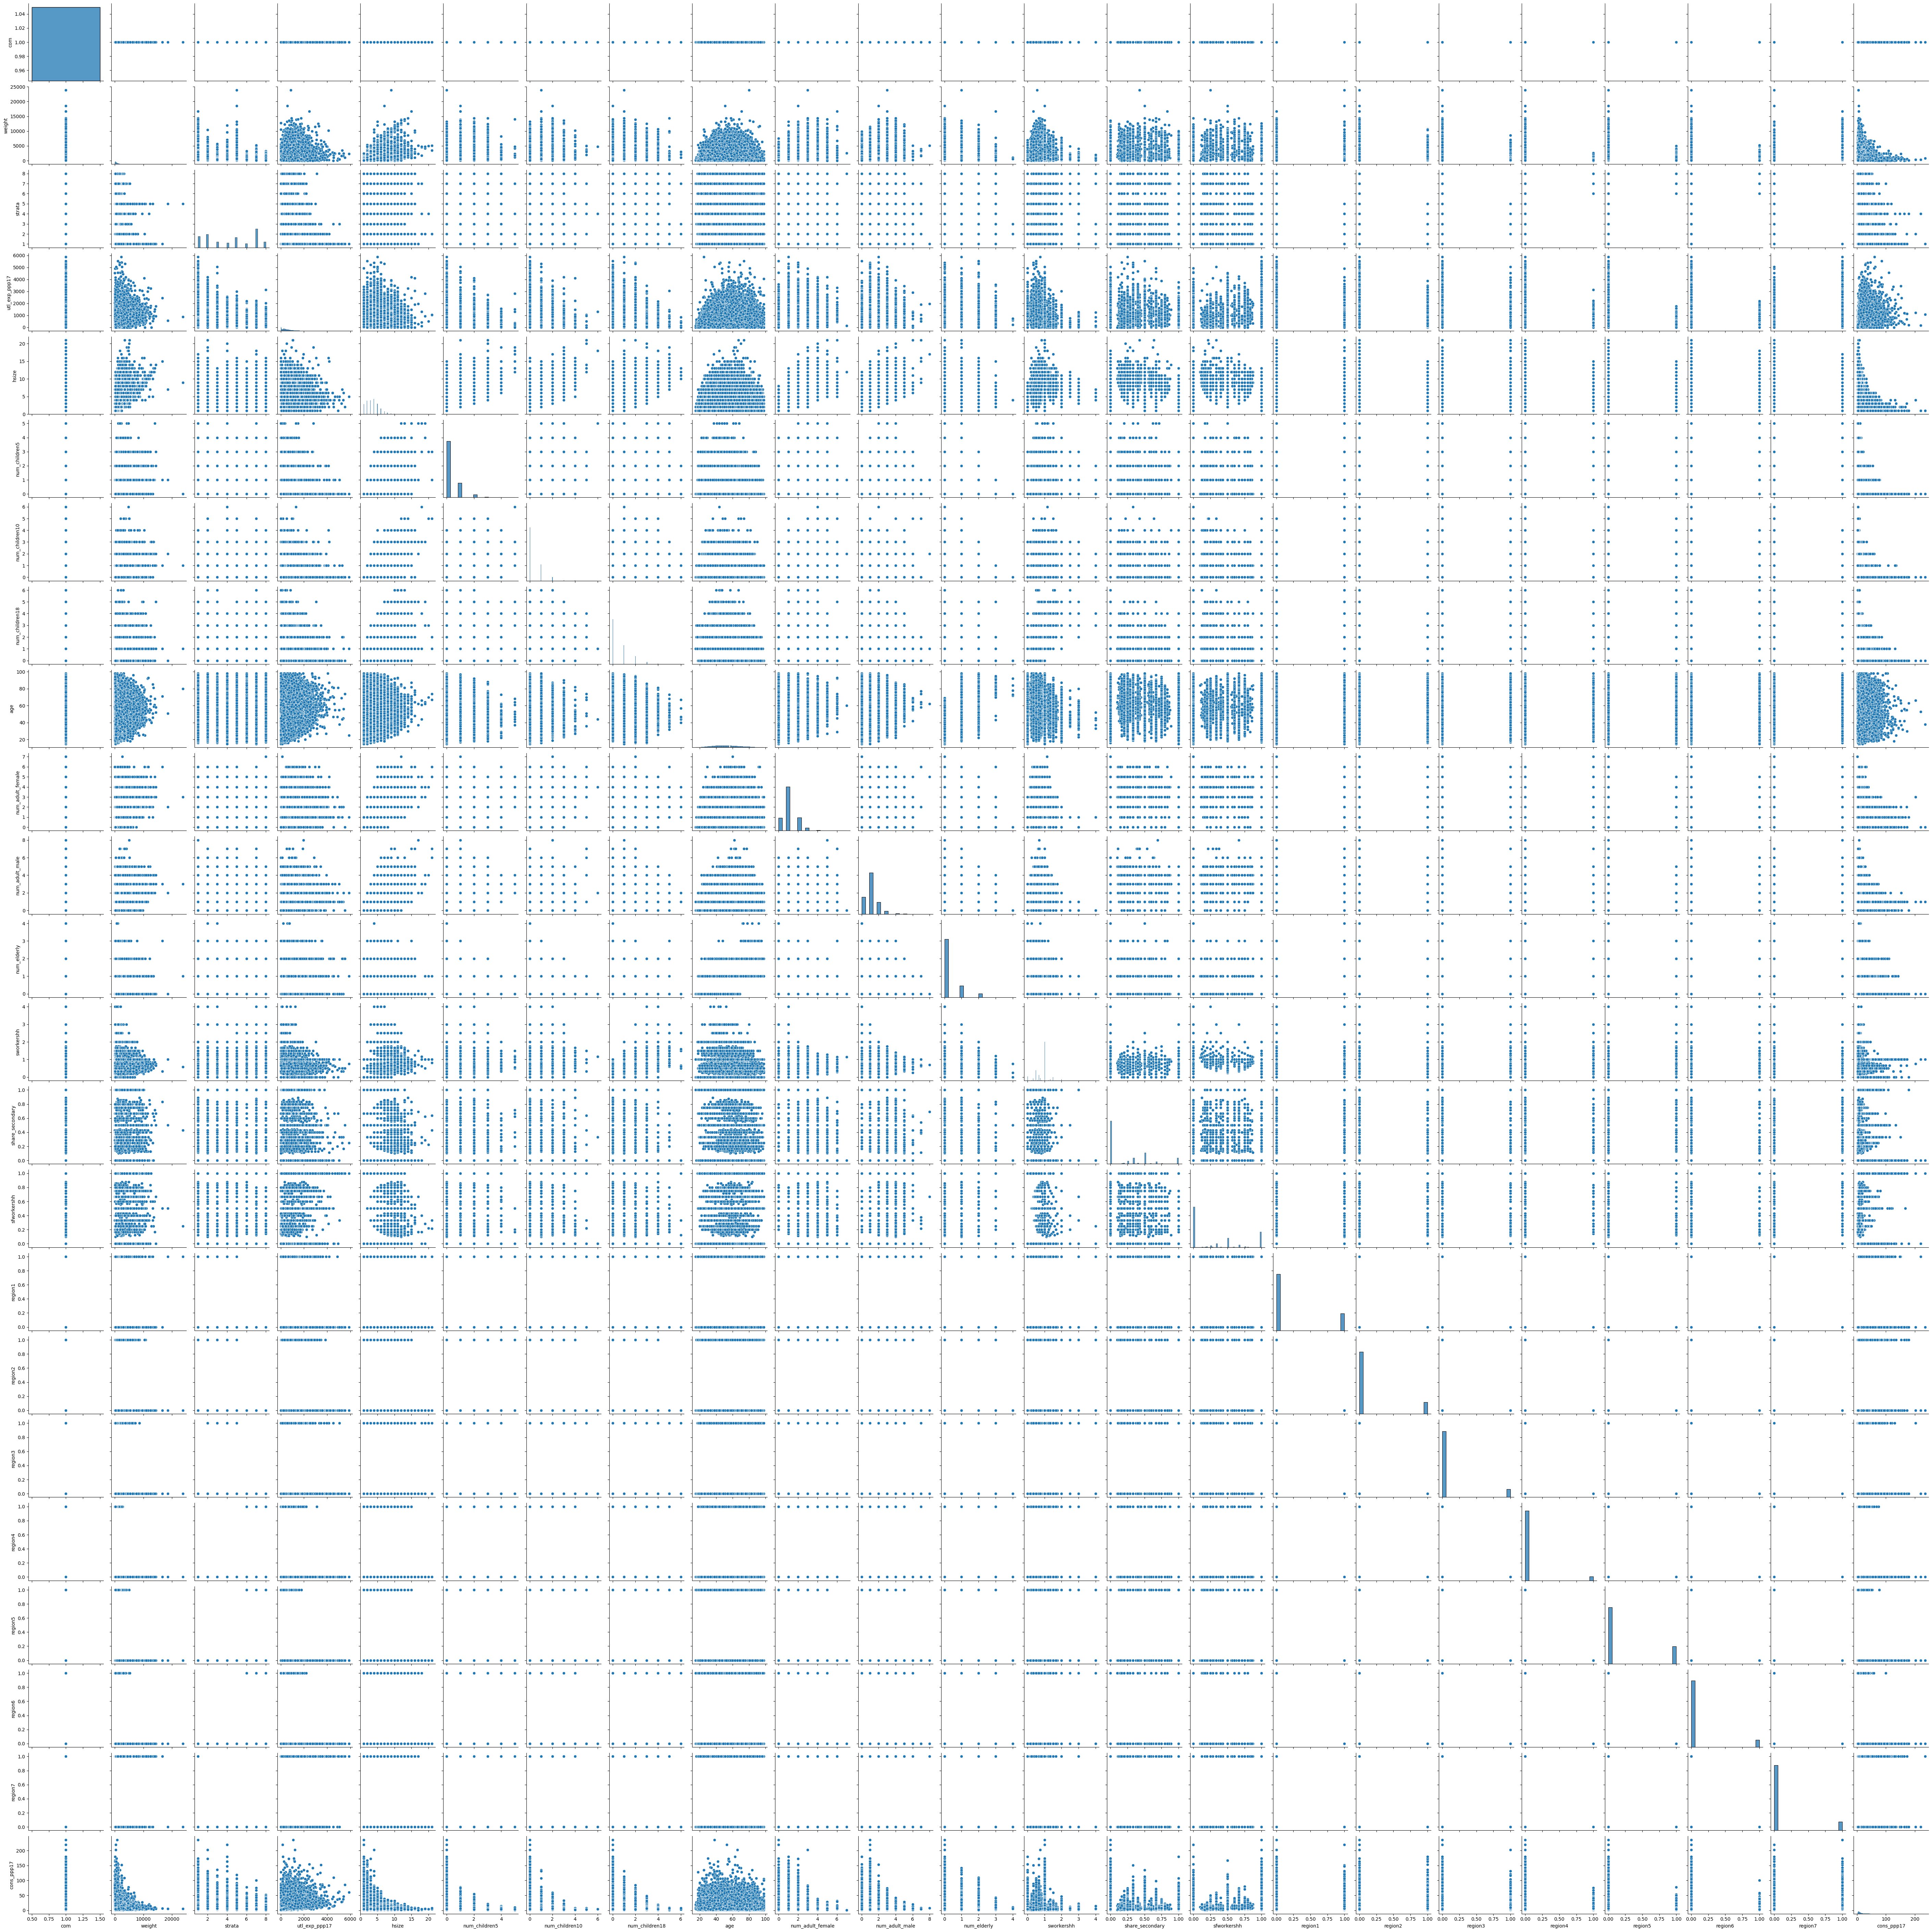

In [6]:
sns.pairplot(df)
plt.show()
#plt.savefig("pairplot.png")

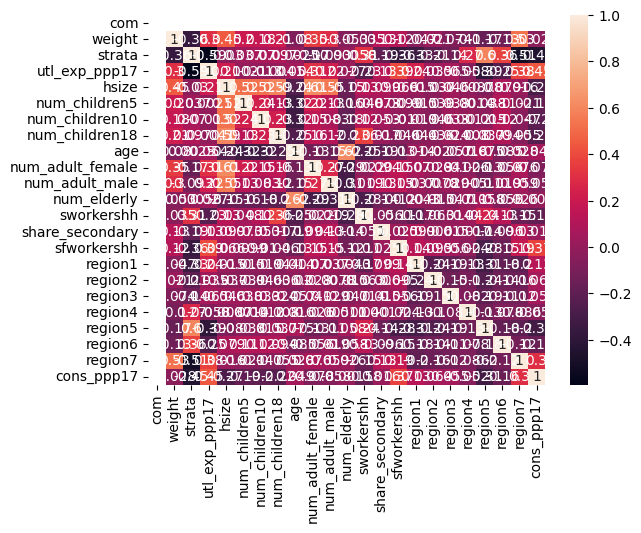

<Figure size 640x480 with 0 Axes>

In [7]:
corr = df.select_dtypes(include='number').corr()
corr.style.background_gradient(cmap='coolwarm')

sns.heatmap(corr, annot=True)
plt.show()
plt.savefig("heatmap.png")

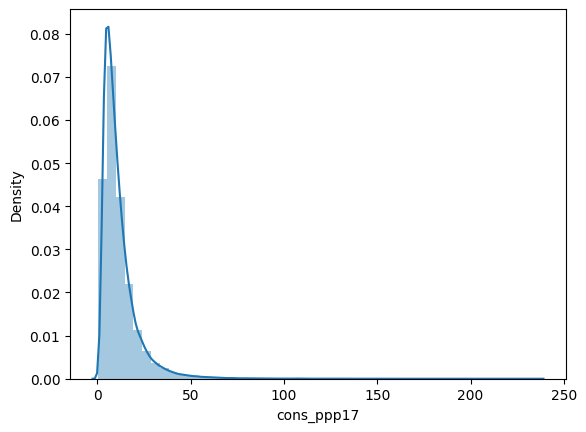

<Figure size 640x480 with 0 Axes>

In [8]:
#Distribution in Data
sns.distplot(df["cons_ppp17"])
plt.show()
plt.savefig("distplot.png")

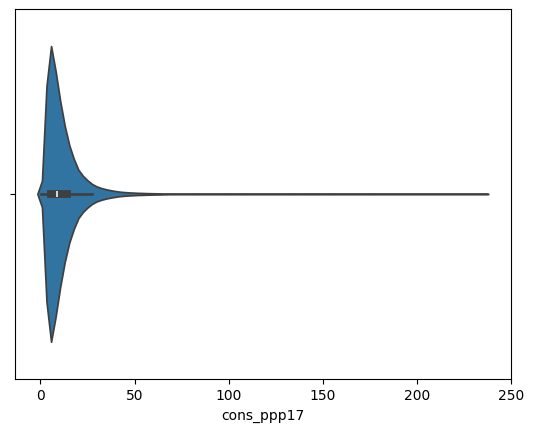

In [9]:
#Violin Plot
sns.violinplot(x=df["cons_ppp17"])
plt.show()
#plt.savefig("violinplot.png")

## Feature Engineering

In [10]:
str_features = [column for column in df.select_dtypes(include="object")]

In [11]:
#Label Encoding Features
encoder = LabelEncoder()
for column in str_features:
  df[column] = encoder.fit_transform(df[[column]])

In [12]:
df

com  weight  strata  utl_exp_ppp17  male  hsize  num_children5  \
0         1      75       4      594.80627     0      1              0   
1         1     150       4     1676.27230     0      2              0   
2         1     375       4      506.93719     1      5              0   
3         1     375       4      824.61786     1      5              0   
4         1     525       4      351.47644     1      7              1   
...     ...     ...     ...            ...   ...    ...            ...   
104229    1     616       7      143.58849     0      4              2   
104230    1     616       7      268.44803     0      4              0   
104231    1    1540       7      243.47612     1     10              2   
104232    1    1232       7      337.12079     1      8              0   
104233    1     154       7      243.47612     0      1              0   

        num_children10  num_children18  age  ...  consumed4200  consumed4300  \
0                    0               0   75  ...             1             0   
1                    0               0   61  ...             1             0   
2                    0               2   49  ...             1             1   
3                    0               1   58  ...             0             1   
4                    0               0   57  ...             1             0   
...                ...             ...  ...  ...           ...           ...   
104229               1               0   33  ...             1             0   
104230               0               1   48  ...             1             0   
104231               3               2   54  ...             1             0   
104232               0               3   49  ...             1             1   
104233               0               0   76  ...             1             0   

        consumed4400  consumed4500  consumed4600  consumed4700  consumed4800  \
0                  0             0             1             1             1   
1                  0             0             0             1             1   
2                  0             1             1             1             1   
3                  0             0             0             1             1   
4                  0             1             0             1             1   
...              ...           ...           ...           ...           ...   
104229             0             0             0             1             1   
104230             0             0             0             1             0   
104231             0             1             0             1             1   
104232             0             1             0             0             1   
104233             0             1             0             1             0   

        consumed4900  consumed5000  cons_ppp17  
0                  1             0   25.258402  
1                  0             0   16.996706  
2                  0             1   13.671848  
3                  0             0    7.189475  
4                  1             0   12.308855  
...              ...           ...         ...  
104229             0             1    2.830888  
104230             0             0    3.144309  
104231             0             0    3.319158  
104232             1             1    6.088739  
104233             0             0    3.635263  

[104234 rows x 87 columns]

In [13]:
df.isna().sum()

com               0
weight            0
strata            0
utl_exp_ppp17    85
male              0
                 ..
consumed4700      0
consumed4800      0
consumed4900      0
consumed5000      0
cons_ppp17        0
Length: 87, dtype: int64

In [14]:
imputer = SimpleImputer(strategy="median")
df["utl_exp_ppp17"] = imputer.fit_transform(df[["utl_exp_ppp17"]])

## Modelling

In [15]:
X = df.drop("cons_ppp17", axis=1)
y = df["cons_ppp17"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X

com  weight  strata  utl_exp_ppp17  male  hsize  num_children5  \
0         1      75       4      594.80627     0      1              0   
1         1     150       4     1676.27230     0      2              0   
2         1     375       4      506.93719     1      5              0   
3         1     375       4      824.61786     1      5              0   
4         1     525       4      351.47644     1      7              1   
...     ...     ...     ...            ...   ...    ...            ...   
104229    1     616       7      143.58849     0      4              2   
104230    1     616       7      268.44803     0      4              0   
104231    1    1540       7      243.47612     1     10              2   
104232    1    1232       7      337.12079     1      8              0   
104233    1     154       7      243.47612     0      1              0   

        num_children10  num_children18  age  ...  consumed4100  consumed4200  \
0                    0               0   75  ...             1             1   
1                    0               0   61  ...             1             1   
2                    0               2   49  ...             1             1   
3                    0               1   58  ...             0             0   
4                    0               0   57  ...             1             1   
...                ...             ...  ...  ...           ...           ...   
104229               1               0   33  ...             1             1   
104230               0               1   48  ...             0             1   
104231               3               2   54  ...             1             1   
104232               0               3   49  ...             1             1   
104233               0               0   76  ...             0             1   

        consumed4300  consumed4400  consumed4500  consumed4600  consumed4700  \
0                  0             0             0             1             1   
1                  0             0             0             0             1   
2                  1             0             1             1             1   
3                  1             0             0             0             1   
4                  0             0             1             0             1   
...              ...           ...           ...           ...           ...   
104229             0             0             0             0             1   
104230             0             0             0             0             1   
104231             0             0             1             0             1   
104232             1             0             1             0             0   
104233             0             0             1             0             1   

        consumed4800  consumed4900  consumed5000  
0                  1             1             0  
1                  1             0             0  
2                  1             0             1  
3                  1             0             0  
4                  1             1             0  
...              ...           ...           ...  
104229             1             0             1  
104230             0             0             0  
104231             1             0             0  
104232             1             1             1  
104233             0             0             0  

[104234 rows x 86 columns]

In [17]:
#Models
enet = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", ElasticNet(
      alpha=0.01,        # overall regularization strength
      l1_ratio=0.5,      # balance between L1 and L2
      max_iter=5000,
      tol=1e-4,
      random_state=42
  ))
])

rfr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(
      n_estimators=500,
      max_depth=12,
      min_samples_split=10,
      min_samples_leaf=5,
      max_features="sqrt",
      bootstrap=True,
      random_state=42,
      n_jobs=-1
  ))
])

gbt = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,
        random_state=42
    ))
])

xgb = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBRegressor(
      n_estimators=500,
      learning_rate=0.05,
      max_depth=4,
      min_child_weight=5,
      subsample=0.8,
      colsample_bytree=0.8,
      gamma=0.1,
      reg_alpha=0.1,
      reg_lambda=1.0,
      objective="reg:squarederror",
      random_state=42,
      n_jobs=-1
  ))
])

lgbm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LGBMRegressor(
      n_estimators=600,
      learning_rate=0.05,
      num_leaves=31,
      max_depth=-1,
      min_child_samples=20,
      subsample=0.8,
      colsample_bytree=0.8,
      reg_alpha=0.1,
      reg_lambda=1.0,
      random_state=42,
      n_jobs=-1
  ))
])

In [18]:
models = {"Elasticnet Regression": enet, "Random Forest Regression": rfr, "Gradient Boosting Regression": gbt, "XGBoost Regression": xgb, "LightGBM Regression": lgbm}

ngrok.kill()
conf.get_default().auth_token = "36ixhiHsnuoRD2cH2ZCuo9jgdSD_5mdK6AFEwkJJRBNPzmi9P"
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)
ngrok.connect(5000)
record = int(time())

with mlflow.start_run(run_name=f"run_{record}"):
  for name, model in zip(models.keys(), models.values()):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = model.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean((y_test - y_pred) / y_test) * 100
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} MAE: {mae}")
    print(f"{name} MSE: {mse}")
    print(f"{name} MAPE: {mape}")
    print(f"{name} R2: {r2}")


    mlflow.log_metric(f"{name} Accuracy", accuracy)
    mlflow.log_metric(f"{name} MAE", mae)
    mlflow.log_metric(f"{name} MSE", mse)
    mlflow.log_metric(f"{name} MAPE", mape)
    mlflow.log_metric(f"{name} R2", r2)

    mlflow.sklearn.log_model(
      sk_model=model,
      artifact_path="model",
      registered_model_name=name
    )

MLflow Tracking UI: https://nomographical-olga-orderingly.ngrok-free.dev


2026/01/11 10:19:04 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/11 10:19:04 INFO mlflow.store.db.utils: Updating database tables
2026/01/11 10:19:04 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/11 10:19:04 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/11 10:19:04 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/11 10:19:04 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/11 10:19:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Elasticnet Regression Accuracy: 0.4945521979724562
Elasticnet Regression MAE: 4.288610724085324
Elasticnet Regression MSE: 50.78250917874574
Elasticnet Regression MAPE: -14.835252258194526
Elasticnet Regression R2: 0.4945521979724562


2026/01/11 10:19:10 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/11 10:19:10 INFO mlflow.store.db.utils: Updating database tables
2026/01/11 10:19:10 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/11 10:19:10 INFO alembic.runtime.migration: Will assume non-transactional DDL.
Registered model 'Elasticnet Regression' already exists. Creating a new version of this model...
Created version '2' of model 'Elasticnet Regression'.
2026/01/11 10:19:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Random Forest Regression Accuracy: 0.5854417076314429
Random Forest Regression MAE: 3.672251332436287
Random Forest Regression MSE: 41.650809842050116
Random Forest Regression MAPE: -22.41196797694242
Random Forest Regression R2: 0.5854417076314429


Registered model 'Random Forest Regression' already exists. Creating a new version of this model...
Created version '2' of model 'Random Forest Regression'.
2026/01/11 10:21:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Gradient Boosting Regression Accuracy: 0.633015518978945
Gradient Boosting Regression MAE: 3.4607426097233
Gradient Boosting Regression MSE: 36.87105315554108
Gradient Boosting Regression MAPE: -14.698998914749922
Gradient Boosting Regression R2: 0.633015518978945


Registered model 'Gradient Boosting Regression' already exists. Creating a new version of this model...
Created version '2' of model 'Gradient Boosting Regression'.
2026/01/11 10:21:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


XGBoost Regression Accuracy: 0.6575659556217437
XGBoost Regression MAE: 3.326539225954424
XGBoost Regression MSE: 34.404462601276094
XGBoost Regression MAPE: -13.162824743051226
XGBoost Regression R2: 0.6575659556217437


Registered model 'XGBoost Regression' already exists. Creating a new version of this model...
Created version '2' of model 'XGBoost Regression'.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 83387, number of used features: 85
[LightGBM] [Info] Start training from score 11.564958


2026/01/11 10:21:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


LightGBM Regression Accuracy: 0.6705687027501668
LightGBM Regression MAE: 3.2755704746998497
LightGBM Regression MSE: 33.09807226235425
LightGBM Regression MAPE: -12.897725673223526
LightGBM Regression R2: 0.6705687027501668


Registered model 'LightGBM Regression' already exists. Creating a new version of this model...
Created version '2' of model 'LightGBM Regression'.


## Statistical testing

In [19]:
#Cross Validation function
def cross_val_regression(model, X, y, cv):
    metrics = []
    y_true_all = []
    y_pred_all = []

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        metrics.append({
            "fold": fold,
            "mae": mean_absolute_error(y_test, preds),
            "mse": mean_squared_error(y_test, preds),
            "r2": r2_score(y_test, preds)
        })

        y_true_all.append(y_test.values)
        y_pred_all.append(preds)

    return metrics, np.concatenate(y_true_all), np.concatenate(y_pred_all)


In [20]:
#Necessary errors
err_enet = np.abs(y_test - enet.predict(X_test))
err_rfr = np.abs(y_test - rfr.predict(X_test))
err_gbt = np.abs(y_test - gbt.predict(X_test))
err_xgb = np.abs(y_test - xgb.predict(X_test))
err_lgbm = np.abs(y_test - lgbm.predict(X_test))

In [21]:
#Necessary CV variables
cv = KFold(n_splits=5, shuffle=True, random_state=42)

lgb_metrics, y_true_lgb, y_pred_lgb = cross_val_regression(
    lgbm, X, y, cv
)

xgb_metrics, y_true_xgb, y_pred_xgb = cross_val_regression(
    xgb, X, y, cv
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 83387, number of used features: 85
[LightGBM] [Info] Start training from score 11.564958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1065
[LightGBM] [Info] Number of data points in the train set: 83387, number of used features: 85
[LightGBM] [Info] Start training from score 11.548261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [22]:
#Diebold-Mariano's Test
from scipy.stats import norm

def diebold_mariano(e1, e2):
    d = e1 - e2
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d / len(d))
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))
    return dm_stat, p_value

In [23]:
dm_stat, p_val = diebold_mariano(err_lgbm, err_xgb)
print("DM stat:", dm_stat)
print("p-value:", p_val)

DM stat: -6.735420451152046
p-value: 1.6345591546951255e-11


In [24]:
def summarize_cv(metrics):
    return {
        k: np.mean([m[k] for m in metrics])
        for k in metrics[0] if k != "fold"
    }

print("LightGBM CV:", summarize_cv(lgb_metrics))
print("XGBoost CV:", summarize_cv(xgb_metrics))

LightGBM CV: {'mae': np.float64(3.2778735045613367), 'mse': np.float64(34.368294992328515), 'r2': np.float64(0.658863431858111)}
XGBoost CV: {'mae': np.float64(3.326096403801447), 'mse': np.float64(35.08053919011009), 'r2': np.float64(0.6518065183412117)}


In [25]:
#Paired T-Test
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(err_lgbm, err_xgb)

print("t-stat:", t_stat)
print("p-value:", p_value)

t-stat: -6.73542045115205
p-value: 1.6771567044407405e-11


In [26]:
#Paired Bootstrap Test
def paired_bootstrap_test(
    y_true, pred_a, pred_b,
    loss="mse", n_boot=5000, seed=42
):
    rng = np.random.default_rng(seed)

    if loss == "mse":
        err_a = (y_true - pred_a) ** 2
        err_b = (y_true - pred_b) ** 2
    elif loss == "mae":
        err_a = np.abs(y_true - pred_a)
        err_b = np.abs(y_true - pred_b)
    else:
        raise ValueError("Unsupported loss")

    diff = np.array(err_a - err_b)  # <-- force numpy array
    n = len(diff)

    idx = rng.integers(0, n, size=(n_boot, n))
    boot_means = diff[idx].mean(axis=1)

    mean_diff = diff.mean()
    ci_low, ci_high = np.percentile(boot_means, [2.5, 97.5])

    # Proper two-sided bootstrap p-value
    p_value = np.mean(np.abs(boot_means) >= np.abs(mean_diff))

    return {
        "mean_diff": mean_diff,
        "ci_95": (ci_low, ci_high),
        "p_value": p_value,
        "interpretation": "Model B better" if mean_diff > 0 else "Model A better"
    }

In [27]:
y_pred_lgbm = lgbm.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

res = paired_bootstrap_test(
    y_test, y_pred_lgbm, y_pred_xgb, loss="mse"
)

print(res)


{'mean_diff': np.float64(-8.812688216785407), 'ci_95': (np.float64(-10.667146823047677), np.float64(-7.308567184217396)), 'p_value': np.float64(0.4834), 'interpretation': 'Model A better'}


In [28]:
#Wilcoxxon Signed Rank Test
def wilcoxon_model_comparison(y_true, preds_dict):
    from itertools import combinations
    from scipy.stats import wilcoxon
    import pandas as pd
    import numpy as np

    # Make errors
    errors = {k: np.abs(y_true - v) for k, v in preds_dict.items()}
    results = []

    for (a_name, a_err), (b_name, b_err) in combinations(errors.items(), 2):
        stat, p = wilcoxon(a_err, b_err, alternative='two-sided')
        mean_diff = np.mean(a_err - b_err)
        results.append({
            "Model A": a_name,
            "Model B": b_name,
            "Mean Error Diff (A-B)": mean_diff,
            "Wilcoxon Stat": stat,
            "p-value": p,
            "Interpretation": (
                f"{b_name} better" if mean_diff > 0 else f"{a_name} better"
            )
        })

    return pd.DataFrame(results)

In [29]:
#getting necssary predictions of each model for signed rank test
y_pred_enet = enet.predict(X_test)
y_pred_rfr = rfr.predict(X_test)
y_pred_gbt = gbt.predict(X_test)
y_pred_lgbm = lgbm.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

preds_dict = {
    "LGBM": y_pred_lgbm,
    "XGB": y_pred_xgb,
    "RF": y_pred_rfr,
    "GB": y_pred_gbt,
    "ElasticNet": y_pred_enet
}

df_wilcoxon = wilcoxon_model_comparison(y_test.values.ravel(), preds_dict)
print(df_wilcoxon)

  Model A     Model B  Mean Error Diff (A-B)  Wilcoxon Stat        p-value  \
0    LGBM         XGB              -0.290074     85545659.0  7.895099e-156   
1    LGBM          RF              -0.753541     70365003.0   0.000000e+00   
2    LGBM          GB              -0.542032     73987772.0   0.000000e+00   
3    LGBM  ElasticNet              -1.369900     54744472.0   0.000000e+00   
4     XGB          RF              -0.463466     80612470.0  1.753055e-228   
5     XGB          GB              -0.251957     84075371.0  5.084011e-176   
6     XGB  ElasticNet              -1.079826     60907525.0   0.000000e+00   
7      RF          GB               0.211509     91655984.0   3.234419e-85   
8      RF  ElasticNet              -0.616359     79957825.0  3.561334e-239   
9      GB  ElasticNet              -0.827868     68843754.0   0.000000e+00   

  Interpretation  
0    LGBM better  
1    LGBM better  
2    LGBM better  
3    LGBM better  
4     XGB better  
5     XGB better  
6     XG

## Stress Testing

In [30]:
#Noise Injection Test
def stress_test_noise(model, X, y, noise_levels=[0.01, 0.05, 0.1]):
    results = []

    for sigma in noise_levels:
        X_noisy = X + np.random.normal(0, sigma, X.shape)
        y_pred = model.predict(X_noisy)

        results.append({
            "noise_std": sigma,
            "mae": mean_absolute_error(y, y_pred),
            "mse": mean_squared_error(y, y_pred),
            "r2": r2_score(y, y_pred)
        })

    return pd.DataFrame(results)

In [31]:
#Domain Shift
def stress_test_shift(model, X, y, shift_factors=[0.9, 1.1, 1.2]):
    results = []

    for factor in shift_factors:
        X_shifted = X.copy()
        # Example: scale 'income' feature
        if 'income' in X.columns:
            X_shifted['income'] = X_shifted['income'] * factor
        y_pred = model.predict(X_shifted)
        results.append({
            "shift_factor": factor,
            "mae": mean_absolute_error(y, y_pred),
            "mse": mean_squared_error(y, y_pred),
            "r2": r2_score(y, y_pred)
        })

    return pd.DataFrame(results)


In [32]:
#Extreme Value or Outlier Test
def stress_test_outliers(model, X, y, outlier_fraction=0.05, outlier_multiplier=10):
    X_out = X.copy()
    n_outliers = int(len(X) * outlier_fraction)
    idx = np.random.choice(len(X), n_outliers, replace=False)
    X_out.iloc[idx] *= outlier_multiplier
    y_pred = model.predict(X_out)

    return {
        "mae": mean_absolute_error(y, y_pred),
        "mse": mean_squared_error(y, y_pred),
        "r2": r2_score(y, y_pred)
    }

In [33]:
# dictionary of models
models = {
    "LGBM": lgbm,
    "XGB": xgb,
    "RF": rfr,
    "GB": gbt,
    "ElasticNet": enet
}

# Define scenarios
noise_levels = [0.01, 0.05, 0.1]
shift_factors = [0.9, 1.1, 1.2]
outlier_fraction = 0.05
outlier_multiplier = 10


stress_results = {}

for name, model in models.items():
    print(f"Stress testing {name}...")

    stress_results[name] = {
        "noise": stress_test_noise(model, X_test, y_test, noise_levels),
        "shift": stress_test_shift(model, X_test, y_test, shift_factors),
        "outliers": stress_test_outliers(model, X_test, y_test,
                                         outlier_fraction, outlier_multiplier)
    }

stress_res = pd.DataFrame(stress_results)
noise_df = pd.concat([stress_results[m]["noise"].assign(Model=m) for m in models.keys()], ignore_index=True)
shift_df = pd.concat([stress_results[m]["shift"].assign(Model=m) for m in models.keys()], ignore_index=True)
outlier_df = pd.DataFrame([
    {"Model": name, **stress_results[name]["outliers"]}
    for name in models.keys()
])


# Noise
print(noise_df.groupby("Model")["mae"].mean().sort_values())

# Shift
print(shift_df.groupby("Model")["mae"].mean().sort_values())

# Outliers
print(outlier_df.sort_values("mae"))

Stress testing LGBM...
Stress testing XGB...
Stress testing RF...
Stress testing GB...
Stress testing ElasticNet...
Model
LGBM          3.079850
GB            3.457837
RF            3.676037
XGB           4.087497
ElasticNet    4.313330
Name: mae, dtype: float64
Model
LGBM          2.918711
XGB           3.208785
GB            3.460743
RF            3.672251
ElasticNet    4.288611
Name: mae, dtype: float64
        Model       mae         mse        r2
0        LGBM  3.109772   26.666481  0.734584
1         XGB  3.378823   34.793640  0.653692
3          GB  3.665363   40.308676  0.598800
2          RF  3.724162   42.786265  0.574140
4  ElasticNet  7.285889  360.563705 -2.588758


## Impossibility Testing

In [34]:
def impossibility_test(model, X_test, y_test, scenario="extreme_outliers", factor=100):
    """
    Apply impossibility scenario to X_test and evaluate model.

    Parameters
    ----------
    model: fitted regressor
    X_test: pd.DataFrame
    y_test: pd.Series
    scenario: str, type of impossibility
    factor: float, multiplier for extreme values

    Returns
    -------
    dict: {'mae': ..., 'mse': ..., 'r2': ...}
    """
    X_imp = X_test.copy()

    if scenario == "extreme_outliers":
        X_imp = X_imp * factor  # blow up feature values
    elif scenario == "feature_flip":
        X_imp = -X_imp  # invert all features
    elif scenario == "random_noise":
        X_imp = pd.DataFrame(np.random.normal(0, 1, X_imp.shape), columns=X_imp.columns)
    elif scenario == "nan_injection":
        X_imp = X_imp.copy()
        X_imp[:] = np.nan
    else:
        raise ValueError(f"Unsupported scenario: {scenario}")

    try:
        y_pred = model.predict(X_imp)
        mae = np.mean(np.abs(y_test - y_pred))
        mse = np.mean((y_test - y_pred)**2)
        r2 = 1 - mse / np.var(y_test)
    except Exception as e:
        return {"error": str(e)}

    return {"mae": mae, "mse": mse, "r2": r2}


In [35]:
scenarios = ["extreme_outliers", "feature_flip", "random_noise", "nan_injection"]

impossibility_results = {}

for name, model in models.items():
    print(f"Impossibility testing {name}...")
    impossibility_results[name] = {}
    for sc in scenarios:
        impossibility_results[name][sc] = impossibility_test(model, X_test, y_test, scenario=sc)


Impossibility testing LGBM...
Impossibility testing XGB...
Impossibility testing RF...
Impossibility testing GB...
Impossibility testing ElasticNet...


In [36]:
imp_df = pd.DataFrame([
    {"Model": name, "Scenario": sc, **impossibility_results[name][sc]}
    for name in models.keys()
    for sc in scenarios
])
imp_df

Model          Scenario         mae            mse           r2
0         LGBM  extreme_outliers    6.933798     117.103004    -0.165548
1         LGBM      feature_flip   14.377020     251.839877    -1.506609
2         LGBM      random_noise   19.733353     473.692654    -3.714751
3         LGBM     nan_injection    6.091272     106.426682    -0.059285
4          XGB  extreme_outliers    7.017941     118.736575    -0.181807
5          XGB      feature_flip   12.722214     205.838874    -1.048753
6          XGB      random_noise   17.641072     383.526863    -2.817315
7          XGB     nan_injection    7.416550     105.682528    -0.051878
8           RF  extreme_outliers    4.974944      63.688215     0.366099
9           RF      feature_flip    8.610739     120.644257    -0.200795
10          RF      random_noise    9.203058     136.984647    -0.363434
11          RF     nan_injection    6.220590     102.079780    -0.016019
12          GB  extreme_outliers   11.293020     184.867088    -0.840017
13          GB      feature_flip   12.104303     190.297111    -0.894063
14          GB      random_noise   18.116688     395.343390    -2.934927
15          GB     nan_injection    6.085113     107.562062    -0.070585
16  ElasticNet  extreme_outliers  714.510812  726096.232987 -7225.971470
17  ElasticNet      feature_flip   15.638108     347.217628    -2.455922
18  ElasticNet      random_noise   10.650064     189.232252    -0.883464
19  ElasticNet     nan_injection    6.275364     101.435493    -0.009606

## Model Interpretability

In [37]:
def shap_tree_model(model, X, top_n=20):
    explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
    shap_values = explainer.shap_values(X)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)

    shap_df = pd.DataFrame({
        "feature": X.columns,
        "shap_value": mean_abs_shap
    }).sort_values("shap_value", ascending=False)

    shap.summary_plot(shap_values, X, plot_type="bar", max_display=top_n)
    plt.savefig("shap_summary.png")
    return shap_df


In [38]:
def shap_linear_model(model, X, top_n=20):
    # subsample for extreme speed-up on KernelExplainer
    X_sub = X.sample(min(300, len(X)))

    explainer = shap.KernelExplainer(model.predict, X_sub)
    shap_values = explainer.shap_values(X_sub, nsamples=100)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)

    shap_df = pd.DataFrame({
        "feature": X_sub.columns,
        "shap_value": mean_abs_shap
    }).sort_values("shap_value", ascending=False)

    shap.summary_plot(shap_values, X_sub, plot_type="bar", max_display=top_n)
    plt.savefig("shap_summary.png")
    return shap_df

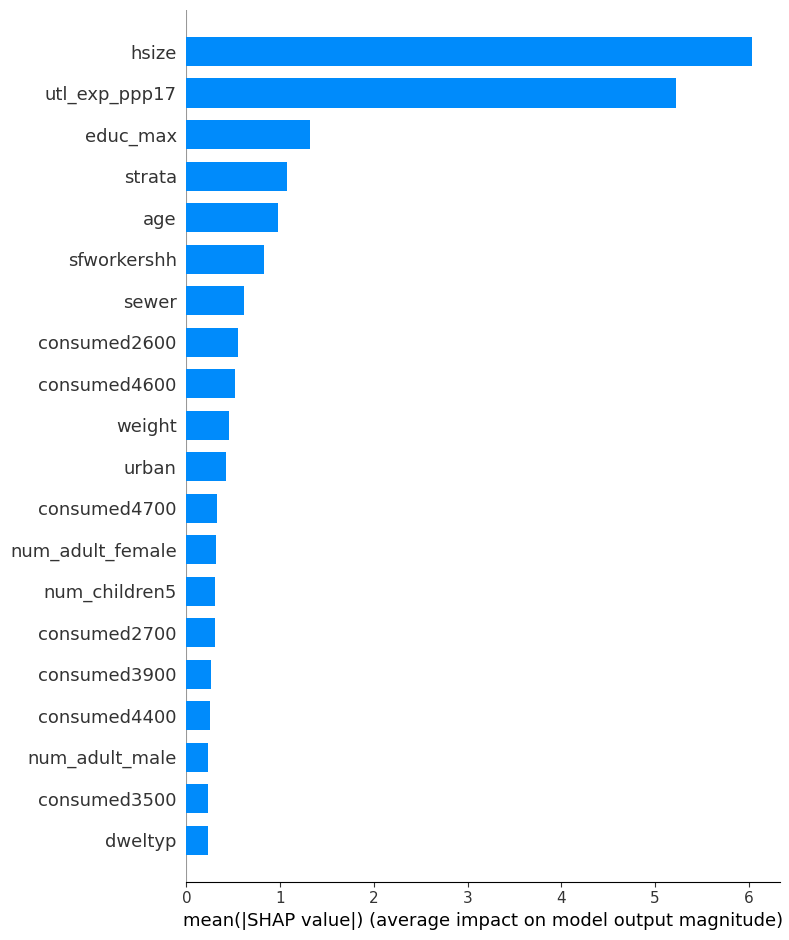

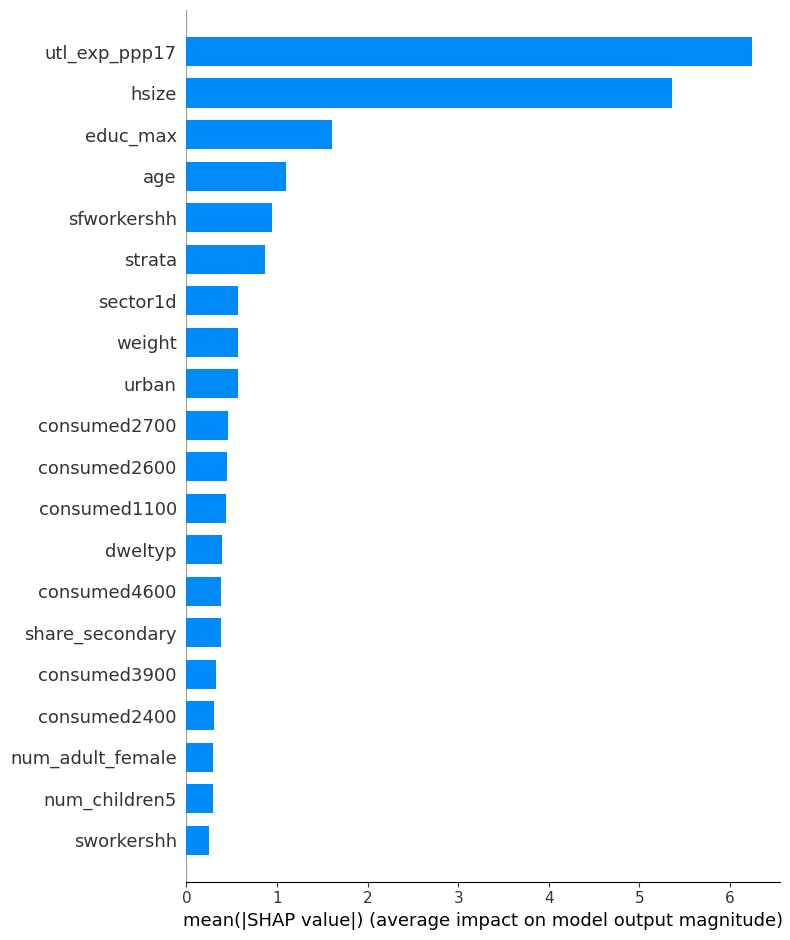

<Figure size 640x480 with 0 Axes>

In [39]:
shap_results = {}

shap_results["LGBM"] = shap_tree_model(lgbm.named_steps["model"], X_test)
shap_results["XGB"]  = shap_tree_model(xgb.named_steps["model"], X_test)



In [40]:
feature_matrix = pd.concat({
    model: df.set_index("feature")["shap_value"]
    for model, df in shap_results.items()
}, axis=1).fillna(0)

feature_matrix["mean_rank"] = feature_matrix.rank(ascending=False).mean(axis=1)
feature_matrix = feature_matrix.sort_values("mean_rank")
feature_matrix.head(20)


LGBM       XGB  mean_rank
feature                                        
hsize             6.031531  5.362453        1.5
utl_exp_ppp17     5.224277  6.239956        1.5
educ_max          1.321259  1.609211        3.0
age               0.976598  1.095950        4.5
strata            1.074197  0.866389        5.0
sfworkershh       0.829715  0.947566        5.5
weight            0.452518  0.570607        9.0
consumed2600      0.549788  0.447379        9.5
urban             0.421164  0.564943       10.0
consumed4600      0.515337  0.383671       11.5
consumed2700      0.299478  0.459553       12.5
sewer             0.608761  0.206239       15.0
num_adult_female  0.318124  0.294223       15.5
consumed3900      0.264597  0.325638       16.0
num_children5     0.302052  0.291822       16.5
dweltyp           0.228079  0.391875       16.5
sector1d          0.163277  0.572837       17.0
consumed4700      0.323612  0.204636       18.0
consumed1100      0.146328  0.431705       20.5
consumed2400      0.173904  0.309186       21.0

## Causal Inference

In [41]:
X = X_test   # features
y = y_test

In [42]:
T = (df['male'] == 0).astype(int)   # treatment = being male

In [43]:
from sklearn.cluster import KMeans

km = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=2, random_state=42))
])

T = km.fit_predict(X)

In [44]:
from causalml.inference.meta import BaseXLearner


x_learner = BaseXLearner(
    LGBMRegressor(),   # outcome model μ(x)
    XGBRegressor(),
    None
)

imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X)

X_imp_df = pd.DataFrame(X_imp, columns=X.columns)
x_learner.fit(
    X=X_imp_df.values,
    treatment=T,     # not T.values
    y=y              # not y.values
)

te = x_learner.predict(X_imp_df.values)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 9201, number of used features: 85
[LightGBM] [Info] Start training from score 8.682126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 928
[LightGBM] [Info] Number of data points in the train set: 11646, number of used features: 85
[LightGBM] [Info] Start training from score 1.181862
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

ATE: -0.579437861102156
median: -0.26391468269644947


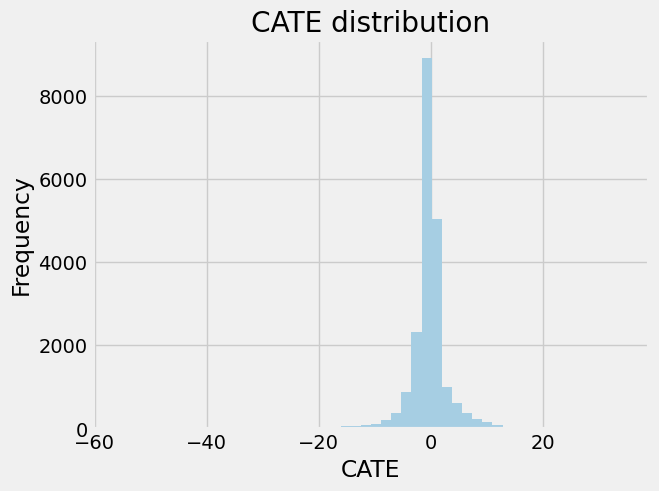

In [45]:
print("ATE:", te.mean())
print("median:", np.median(te))

plt.hist(te, bins=50)
plt.title("CATE distribution")
plt.xlabel("CATE")
plt.ylabel("Frequency")
plt.savefig("cate_hist.png")
plt.show()

## A/B Testing

In [46]:
ATE = np.mean(te)
ATT = np.mean(te[T == 1])
ATC = np.mean(te[T == 0])

print("ATE:", ATE)
print("ATT:", ATT)
print("ATC:", ATC)

ATE: -0.579437861102156
ATT: -2.320505494587798
ATC: 0.7961042388206838


H0: treatment effect = 0
H1: treatment effect ≠ 0

if p_val < 0.05 → statistically significant effect
else → no detectable effect

In [47]:
from scipy.stats import ttest_1samp
t_stat, p_val = ttest_1samp(te, 0)

print("t-stat:", t_stat)
print("p-value:", p_val)

t-stat: [-19.03009235]
p-value: [4.58820765e-80]


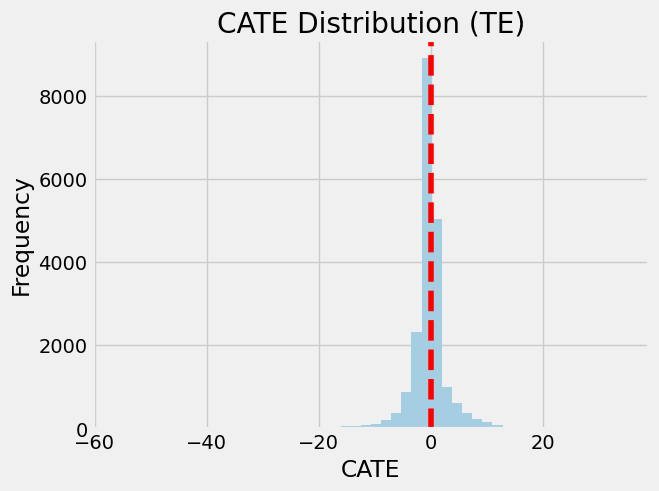

In [48]:
plt.hist(te, bins=50)
plt.axvline(0, color='red', linestyle='--')
plt.title("CATE Distribution (TE)")
plt.xlabel("CATE")
plt.ylabel("Frequency")
plt.savefig("cate_hist.png")
plt.show()

## Generating Predictions for Testing Results

In [49]:
test_df = pd.read_csv("test_hh_features.csv")
test_df


hhid  com  weight  strata  utl_exp_ppp17    male  hsize  \
0       400001    1     320       4      567.80914  Female      4   
1       400002    1     480       4      561.70367  Female      6   
2       400003    1     320       4      183.16423    Male      4   
3       400004    1     320       4      696.02411    Male      4   
4       400005    1     320       4      286.95731    Male      4   
...        ...  ...     ...     ...            ...     ...    ...   
103018  634209    1     963       8      402.71024    Male      3   
103019  634210    1    2247       8      238.44685    Male      7   
103020  634211    1     963       8      211.95276    Male      3   
103021  634212    1     642       8      254.34331  Female      2   
103022  634213    1     963       8      238.44685    Male      3   

        num_children5  num_children10  num_children18  ...  consumed4200  \
0                   0               1               0  ...            No   
1                   0               1               1  ...           Yes   
2                   0               0               0  ...           Yes   
3                   0               0               1  ...           Yes   
4                   0               0               1  ...           Yes   
...               ...             ...             ...  ...           ...   
103018              0               0               0  ...           Yes   
103019              1               2               2  ...           Yes   
103020              0               0               1  ...           Yes   
103021              0               0               0  ...           Yes   
103022              0               0               1  ...           Yes   

       consumed4300 consumed4400 consumed4500 consumed4600 consumed4700  \
0                No           No           No           No          Yes   
1                No           No           No           No          Yes   
2                No          Yes           No          Yes          Yes   
3               Yes           No           No           No          Yes   
4                No           No           No           No           No   
...             ...          ...          ...          ...          ...   
103018           No           No          Yes           No           No   
103019          Yes           No          Yes           No          Yes   
103020           No           No          Yes           No           No   
103021          Yes           No          Yes           No          Yes   
103022           No           No          Yes          Yes          Yes   

       consumed4800 consumed4900 consumed5000  survey_id  
0               Yes          Yes           No     400000  
1               Yes          Yes           No     400000  
2                No          Yes           No     400000  
3               Yes           No           No     400000  
4               Yes           No           No     400000  
...             ...          ...          ...        ...  
103018          Yes          Yes           No     600000  
103019          Yes          Yes           No     600000  
103020          Yes          Yes           No     600000  
103021           No          Yes           No     600000  
103022          Yes          Yes           No     600000  

[103023 rows x 88 columns]

In [50]:
test_str_features = [column for column in test_df.select_dtypes(include="object")]

#Label Encoding Features
encoder = LabelEncoder()
for column in test_str_features:
  test_df[column] = encoder.fit_transform(test_df[[column]])

In [51]:
test_df

hhid  com  weight  strata  utl_exp_ppp17  male  hsize  \
0       400001    1     320       4      567.80914     0      4   
1       400002    1     480       4      561.70367     0      6   
2       400003    1     320       4      183.16423     1      4   
3       400004    1     320       4      696.02411     1      4   
4       400005    1     320       4      286.95731     1      4   
...        ...  ...     ...     ...            ...   ...    ...   
103018  634209    1     963       8      402.71024     1      3   
103019  634210    1    2247       8      238.44685     1      7   
103020  634211    1     963       8      211.95276     1      3   
103021  634212    1     642       8      254.34331     0      2   
103022  634213    1     963       8      238.44685     1      3   

        num_children5  num_children10  num_children18  ...  consumed4200  \
0                   0               1               0  ...             0   
1                   0               1               1  ...             1   
2                   0               0               0  ...             1   
3                   0               0               1  ...             1   
4                   0               0               1  ...             1   
...               ...             ...             ...  ...           ...   
103018              0               0               0  ...             1   
103019              1               2               2  ...             1   
103020              0               0               1  ...             1   
103021              0               0               0  ...             1   
103022              0               0               1  ...             1   

        consumed4300  consumed4400  consumed4500  consumed4600  consumed4700  \
0                  0             0             0             0             1   
1                  0             0             0             0             1   
2                  0             1             0             1             1   
3                  1             0             0             0             1   
4                  0             0             0             0             0   
...              ...           ...           ...           ...           ...   
103018             0             0             1             0             0   
103019             1             0             1             0             1   
103020             0             0             1             0             0   
103021             1             0             1             0             1   
103022             0             0             1             1             1   

        consumed4800  consumed4900  consumed5000  survey_id  
0                  1             1             0     400000  
1                  1             1             0     400000  
2                  0             1             0     400000  
3                  1             0             0     400000  
4                  1             0             0     400000  
...              ...           ...           ...        ...  
103018             1             1             0     600000  
103019             1             1             0     600000  
103020             1             1             0     600000  
103021             0             1             0     600000  
103022             1             1             0     600000  

[103023 rows x 88 columns]

In [53]:
X_test = test_df.copy().drop(columns=["hhid", "survey_id"], axis=1)
preds = preds = lgbm.predict(X_test)

In [54]:
submissions = pd.DataFrame({
    "survey_id": test_df["survey_id"],
    "hhid": test_df["hhid"],
    "cons_ppp17": preds
})

submissions

survey_id    hhid  cons_ppp17
0          400000  400001   12.034811
1          400000  400002    7.958072
2          400000  400003    8.451346
3          400000  400004   14.005855
4          400000  400005    6.487049
...           ...     ...         ...
103018     600000  634209    7.545497
103019     600000  634210    5.117394
103020     600000  634211    6.900763
103021     600000  634212    7.962818
103022     600000  634213    6.868246

[103023 rows x 3 columns]

In [55]:
submissions.to_csv("submissions.csv", index=False)

with open("lgbm_model.pkl", "wb") as f:
    joblib.dump(lgbm, f)